## Linking ACM heterogeneous graph with GPT4
using AutoGen

In [1]:
import dgl
import numpy as np
import urllib
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

In [2]:
import autogen

config_list = autogen.config_list_from_json(
    '''this is a path to a file of the form
    [
      {
        "model": "gpt-4-1106-preview",
        "api_key": "our openai api_key here"
      }
    ]
    ''',
 )

C:\Users\denni\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Loading the ACM graph
The file is ACM.mat in this repo.

In [3]:
data_file_path= 'ACM.mat'
data= scipy.io.loadmat(data_file_path)

We will use dgl's heterograph model for the graph.  unfortunately the data formats have changed to we need to create the correct format.  this function take care of that.

We then create the Graph_data dictionary based on the edge triples connecting the various node typess.

In [5]:
def make_lists(spar):
    As = []
    Bs = []
    x = spar
    for j in range(x.shape[0]):
        y = x.getrow(j).indices
        z = y.copy()
        z[:] = j
        As = As+ list(y)
        Bs = Bs + list(z)
    Asa = np.array(As, dtype= np.int32)
    Bsa = np.array(Bs, dtype= np.int32) 
    return( (Bsa, Asa))

In [6]:
Ggraph_data = {
        ('paper', 'written-by', 'author'): make_lists(data['PvsA']),
        ('author', 'writing', 'paper') : make_lists(data['PvsA'].transpose()),
        ('paper', 'citing', 'paper') : make_lists(data['PvsP']),
        ('paper', 'cited-by', 'paper') : make_lists(data['PvsP'].transpose()),
        ('paper', 'is-about', 'subject') : make_lists(data['PvsL']),
        ('subject', 'has', 'paper') : make_lists(data['PvsL'].transpose()),
        ('paper', 'venue', 'conference'):make_lists(data['PvsC']),
        ('paper', 'in', 'proceedings'):make_lists(data['PvsV']),
        ('proceedings', 'of-conference', 'conference'):make_lists(data['VvsC']),
        ('author', 'from', 'institution'):make_lists(data['AvsF']),
} 

In [7]:
G = dgl.heterograph(Ggraph_data)

### visualize the meta-graph
this is not necessary, but interesting

In [8]:
xG = G.metagraph()

In [9]:
from matplotlib import pyplot as plt
import networkx as nx

In [10]:
*edge, attrs = xG.edges(keys=True, data=True)

In [11]:
labels={
        tuple(edge[0:2]): edge[2]
        for *edge, attrs in xG.edges(keys=True, data=True)
}
labels

{('author', 'institution'): 'from',
 ('author', 'paper'): 'writing',
 ('paper', 'paper'): 'citing',
 ('paper', 'proceedings'): 'in',
 ('paper', 'subject'): 'is-about',
 ('paper', 'conference'): 'venue',
 ('paper', 'author'): 'written-by',
 ('proceedings', 'conference'): 'of-conference',
 ('subject', 'paper'): 'has'}

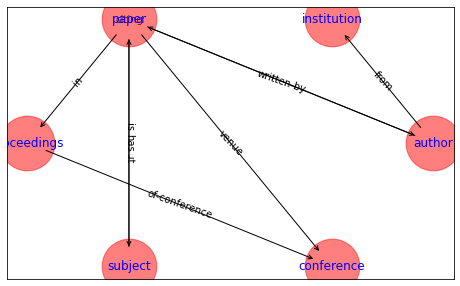

In [12]:
 #f"{attr_name}={attrs[attr_name]}"
fig = plt.figure(figsize=(8, 5))
pos = nx.circular_layout(xG)
names = {name: name for name in xG.nodes}
attr_name = 0
nx.draw_networkx_nodes(xG, pos, node_color = 'r', node_size = 3000, alpha = 0.5)
nx.draw_networkx_labels(xG,pos,names,font_size=12,font_color='b')
nx.draw_networkx_edge_labels(xG, pos, labels)
ax = plt.gca()
for e in xG.edges:
    ax.annotate("",
                xy=pos[e[1]], xycoords='data',
                xytext=pos[e[0]], textcoords='data',
                arrowprops=dict(arrowstyle="->", color="0",
                                shrinkA=20, shrinkB=20,
                                patchA=None, patchB=None,
                                #connectionstyle="arc3,rad=rrr".replace('rrr',str(e[2])
                                ),
                )
#plt.axis('off')

plt.show()

## The Functions
we need functions that will be called by our Autogen agents to access the graph information.   All functions except
find_author_by_name and find_papers_by_title take inputs that are strings encoding list of node IDs.  Thise two function take strings. Also these two functions access the raw data while all others access the graph through the edge relations. note: find paper by title will not work for a paper with a comma in the title.

In [13]:
def author(number):
    return data['A'][number][0][0]

def find_author_by_name(name):
    coa = set()
    for i in range(17430):
        if author(i).find(name)>= 0:
            coa.add((i, author(i)))
    return coa

def find_papers_by_id(papers=""):
    list_of_strings = papers.split(',')
    paper = [int(x) for x in list_of_strings]
    coa = set()
    for pap in paper:
        print(pap)
        coa.add((pap, data['P'][pap][0][0][0:100]))
    return list(coa)


def find_papers_by_title(papers=""):
    paper = papers.split(',')
    coa = set()
    for pap in paper:
        print(pap)
        for i in range(12499):
            if data['P'][i][0][0].find(pap)>= 0:
                coa.add((i, pap))
    return list(coa)
   

def find_authors(papers=''):
    list_of_strings = papers.split(',')
    paper = [int(x) for x in list_of_strings]
    coa = set()
    for pap in paper:
        v = G['written-by'].out_edges(pap)
        q = list(v[1])
        for t in q:
                coa.add((t.item(), data['A'][t.item()][0][0]))
    return coa

def find_papers_by_authors(authors=''):    
    print('arg=', authors)
    list_of_strings = authors.split(',')
    name = [int(x) for x in list_of_strings]
    coa = set()
    for n in name:
        print(n)
        v = G['writing'].out_edges(n)
        q = list(v[1])
        for t in q:
            coa.add((t.item(), data['P'][t.item()][0][0][0:100]))
    return list(coa)
            
def paper_appeared_in(papers=''):
    list_of_strings = papers.split(',')
    paper = [int(x) for x in list_of_strings]
    coa = set()
    for pap in paper:
        v = list(G['venue'].out_edges(pap)[1])
        for t in v:
            coa.add((t.item(), data['C'][t.item()][0][0].item()))
    return list(coa)

def paper_is_about(papers=''):
    list_of_strings = papers.split(',')
    paper = [int(x) for x in list_of_strings]
    coa = set()
    for pap in paper:
        v = list(G['is-about'].out_edges(pap)[1])
        for t in v:
            coa.add((t.item(), data['L'][t.item()][0][0][0:100]))
    return list(coa)

def find_papers_cited_by(papers=''):
    list_of_strings = papers.split(',')
    paper = [int(x) for x in list_of_strings]
    coa = set()
    for pap in paper:
        v = G['cited-by'].out_edges(pap)
        q = list(v[1])
        for t in q:
            coa.add((t.item(), data['P'][t.item()][0][0][0:100]))
    return coa

def find_papers_citing(papers=''):
    list_of_strings = papers.split(',')
    paper = [int(x) for x in list_of_strings]
    coa = set()
    for pap in paper:
        v = G['citing'].out_edges(pap)
        q = list(v[1])
        for t in q:
            coa.add((t.item(), data['P'][t.item()][0][0][0:100]))
    return coa

def find_papers_with_topic(topic=''):
    print("topic=",topic)
    list_of_strings = topic.split(',')
    topics = [int(x) for x in list_of_strings]
    coa = set()
    print("topics=", topics)
    for pap in topics:
        v = list(G['has'].out_edges(pap)[1])
        for t in v:
            coa.add(t.item())
    return list(coa)

def find_proceedings_for_papers(papers=""):
    list_of_strings = papers.split(',')
    paper = [int(x) for x in list_of_strings]
    coa = set()
    for pap in paper:
        v = G['in'].out_edges(pap)
        q = list(v[1])
        for t in q:
            coa.add((t.item(), data['V'][t.item()][0][0][0:100]))
    return coa

def find_conference_of_proceedings(proceedings=''):
    list_of_strings = proceedings.split(',')
    proc = [int(x) for x in list_of_strings]
    coa = set()
    for pap in proc:
        v = list(G['of-conference'].out_edges(pap)[1])[0]
        coa.add((v.item(), data['C'][v][0][0]))
    return list(coa)

def where_is_author_from(authors=''):
    list_of_strings = authors.split(',')
    name = [int(x) for x in list_of_strings]
    coa = set()
    for n in name:
        v = G['from'].out_edges(n)
        q = list(v[1])
        for t in q:
            coa.add(data['F'][t][0][0].item())
    return list(coa)


The functions must be describe for AutoGen in a way that gives semantic descriptions for the language model to use when deciding which function to execute and how to formulate the argument list.

In [237]:
llm_config = {
    "config_list": config_list,
    "seed": 42,
    "functions":[
        {
            "name": "find_author_by_name",
            "description": "retrieves a set of author-id, name pairs",
            "parameters": {
                "type": "object",
                "properties": {
                    "name":{
                        "type": "string",
                        "description": "retieves a set of pairs where each pair is a graph id and a name"
                    }
                },
                "required": ["name"]
            }
        },
        {
            "name": "find_papers_by_authors",
            "description": "retrieves a set of paper-ids, text samples given a set of author-id, name pairs",
            "parameters": {
                "type": "object",
                "properties": {
                    "authors":{
                        "type": "string",
                        "description": "retrieves a set of paper-ids, text samples given a set of author-id, name pairs"
                    }
                },
                "required": ["authors"]
            }
        },
        {
            "name": "find_authors",
            "description": "retrieves a complete list of authors of the papers in the list",
            "parameters": {
                "type": "object",
                "properties": {
                    "papers":{
                        "type": "string",
                        "description": "a list of the paper ids"
                    }
                },
                "required": ["papers"]
            }
        },
        {
            "name": "paper_appeared_in",
            "description": "retrieves a complete list of conferences where papers in the list appeared",
            "parameters": {
                "type": "object",
                "properties": {
                    "papers":{
                        "type": "string",
                        "description": "a list of the paper ids"
                    }
                },
                "required": ["papers"]
            }
        },
         {
            "name": "find_papers_cited_by",
            "description": "retrieves a complete list of conference papers that are cited by the papers in this list",
            "parameters": {
                "type": "object",
                "properties": {
                    "papers":{
                        "type": "string",
                        "description": "a list of the paper ids"
                    }
                },
                "required": ["papers"]
            }
        },
        {
            "name": "find_papers_citing",
            "description": "retrieves a complete list of conference papers that cited the papers in this list",
            "parameters": {
                "type": "object",
                "properties": {
                    "papers":{
                        "type": "string",
                        "description": "a list of the paper ids"
                    }
                },
                "required": ["papers"]
            }
        },
        {
            "name": "find_papers_by_id",
            "description": "retrieves a list of conference papers ids, title pairs that match the paper-ids in this list",
            "parameters": {
                "type": "object",
                "properties": {
                    "papers":{
                        "type": "string",
                        "description": "list of paper-ids"
                    }
                },
                "required": ["papers"]
            }
        },
        {
            "name": "find_papers_by_title",
            "description": "retrieves a list of conference papers ids, title pairs that match the titles in this list",
            "parameters": {
                "type": "object",
                "properties": {
                    "papers":{
                        "type": "string",
                        "description": "list of paper title fragments"
                    }
                },
                "required": ["papers"]
            }
        },
        {
            "name": "paper_is_about",
            "description": "retrieves the topic of a list of papers",
            "parameters": {
                "type": "object",
                "properties": {
                    "papers":{
                        "type": "string",
                        "description": "paper title fragments"
                    }
                },
                "required": ["papers"]
            }
        },
        {
            "name": "find_papers_with_topic",
            "description": "retrieves a list of papers on these topic-id",
            "parameters": {
                "type": "object",
                "properties": {
                    "topic":{
                        "type": "string",
                        "description": "list of topic-Id"
                    }
                },
                "required": ["topic"]
            }
        },
       {
            "name": "find_proceedings_for_papers",
            "description": "retrieves a list of proceedings that contain these paper-ids",
            "parameters": {
                "type": "object",
                "properties": {
                    "papers":{
                        "type": "string",
                        "description": "list of paper-Id"
                    }
                },
                "required": ["papers"]
            }
        },

       {
            "name": "find_conference_of_proceedings",
            "description": "retrieves a the conference ids given these proceedings-ids",
            "parameters": {
                "type": "object",
                "properties": {
                    "proceedings":{
                        "type": "string",
                        "description": "list of proceedings-Id"
                    }
                },
                "required": ["proceedings"]
            }
        },
        {
            "name": "where_is_author_from",
            "description": "retrieves the home institution for a list of author-ids",
            "parameters": {
                "type": "object",
                "properties": {
                    "authors":{
                        "type": "string",
                        "description": "list of authors-Id"
                    }
                },
                "required": ["authors"]
            }
        },    
    ]
}


## The autogen agents
There are only two agents.   The graph_interogator is the one that creates the sequence of graph function calls to be executed to answer the query.  The user_proxy actually executes the calls and returns the results to the graph_interogator.  When the query is complete the graph_interogator summarizes the result and terminates the dialog.

In [238]:
graph_interogator = autogen.AssistantAgent(
    name="graph_interogator",
    system_message='''You interogate the graph and you also generate python code for the user_proxy to execute. 
    when the answer is found issue 'TERMINATE' ''',
    llm_config=llm_config,
)


In [239]:
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    system_message="you are able to execute python programs given to you by the graph_interogator",
    code_execution_config={"use_docker": False},
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
)

In [240]:
user_proxy.register_function(
    function_map={
        "find_author_by_name": find_author_by_name,
        "find_papers_by_authors":find_papers_by_authors,
        "find_authors": find_authors,
        "paper_appeared_in": paper_appeared_in,
        "find_papers_cited_by": find_papers_cited_by,
        "find_papers_citing": find_papers_citing,
        "find_papers_by_id": find_papers_by_id,
        "find_papers_by_title": find_papers_by_title,
        "paper_is_about": paper_is_about,
        "find_papers_with_topic": find_papers_with_topic,
        "find_proceedings_for_papers": find_proceedings_for_papers,
        "find_conference_of_proceedings":find_conference_of_proceedings,
        "where_is_author_from":where_is_author_from,

    }
)

In [227]:
msg = '''find the authors and their home institions of the paper "A model for hierarchical memory" that was presented at COLT'''
user_proxy.initiate_chat(graph_interogator, message=msg) 

user_proxy (to graph_interogator):

find the authors and their home institions of the paper "A model for hierarchical memory" that was presented at COLT

--------------------------------------------------------------------------------
graph_interogator (to user_proxy):

***** Suggested function Call: find_papers_by_title *****
Arguments: 
{"papers":"A model for hierarchical memory"}
*********************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION find_papers_by_title...
A model for hierarchical memory
user_proxy (to graph_interogator):

***** Response from calling function "find_papers_by_title" *****
[(9665, 'A model for hierarchical memory')]
*****************************************************************

--------------------------------------------------------------------------------
graph_interogator (to user_proxy):

***** Suggested function Call: find_authors *****
Arguments

In [228]:
msg = '''find the ids of papers by M. Snir and list the names of his co-authors and their institutions also where were those papers presented and the name of the proceedings'''
user_proxy.initiate_chat(graph_interogator, message=msg) 

user_proxy (to graph_interogator):

find the ids of papers by M. Snir and list the names of his co-authors and their institutions also where were those papers presented and the name of the proceedings

--------------------------------------------------------------------------------
graph_interogator (to user_proxy):

***** Suggested function Call: find_author_by_name *****
Arguments: 
{"name":"M. Snir"}
********************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION find_author_by_name...
user_proxy (to graph_interogator):

***** Response from calling function "find_author_by_name" *****
{(4115, 'M. Snir')}
****************************************************************

--------------------------------------------------------------------------------
graph_interogator (to user_proxy):

***** Suggested function Call: find_papers_by_authors *****
Arguments: 
{"authors":"4115"}
*******

In [241]:
msg = '''find the topics of papers by Lawrence Snyder and find five other papers on the same topic. 
List the titles and proceedings each appeared in. 
'''
user_proxy.initiate_chat(graph_interogator, message=msg) 

user_proxy (to graph_interogator):

find the topics of papers by Lawrence Snyder and find five other papers on the same topic. 
List the titles and proceedings each appeared in. 


--------------------------------------------------------------------------------
graph_interogator (to user_proxy):

***** Suggested function Call: find_author_by_name *****
Arguments: 
{"name":"Lawrence Snyder"}
********************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION find_author_by_name...
user_proxy (to graph_interogator):

***** Response from calling function "find_author_by_name" *****
{(11256, 'Lawrence Snyder'), (2335, 'Lawrence Snyder')}
****************************************************************

--------------------------------------------------------------------------------
graph_interogator (to user_proxy):

***** Suggested function Call: find_papers_by_authors *****
Arguments: 
{"a


--------------------------------------------------------------------------------


In [243]:
msg='who are the authors of paper 9395 and where was the paper presented (conference name and proceedings).'
user_proxy.initiate_chat(graph_interogator, message=msg)

user_proxy (to graph_interogator):

who are the authors of paper 9395 and where was the paper presented (conference name and proceedings).

--------------------------------------------------------------------------------
graph_interogator (to user_proxy):

***** Suggested function Call: find_authors *****
Arguments: 
{"papers":"9395"}
*************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION find_authors...
user_proxy (to graph_interogator):

***** Response from calling function "find_authors" *****
{(16401, 'Uzi Vishkin')}
*********************************************************

--------------------------------------------------------------------------------
graph_interogator (to user_proxy):

***** Suggested function Call: paper_appeared_in *****
Arguments: 
{"papers":"9395"}
******************************************************

--------------------------------------------------

In [179]:
msg = '''i would like to find all the titles of papers cited by papers by "Hopcroft". For each of these find the venue and proceedings where they appeared.
please list the title, venue and conference'''
user_proxy.initiate_chat(graph_interogator, message=msg) 

user_proxy (to graph_interogator):

i would like to find all the titles of papers cited by papers by "Hopcroft". For each of these find the venue and proceedings where they appeared.
please list the title, venue and conference

--------------------------------------------------------------------------------
graph_interogator (to user_proxy):

***** Suggested function Call: find_author_by_name *****
Arguments: 
{"name":"Hopcroft"}
********************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION find_author_by_name...
user_proxy (to graph_interogator):

***** Response from calling function "find_author_by_name" *****
{(102, 'J. Hopcroft')}
****************************************************************

--------------------------------------------------------------------------------
graph_interogator (to user_proxy):

***** Suggested function Call: find_papers_by *****
Arguments: 
{"au


--------------------------------------------------------------------------------


In [244]:
msg= '''Please find the authors and proceedings where the paper titled "Group formation in large social networks: membership, growth and evolution"
was published.  Also please list the home instituion of the authors'''
user_proxy.initiate_chat(graph_interogator, message=msg)

user_proxy (to graph_interogator):

Please find the authors and proceedings where the paper titled "Group formation in large social networks: membership, growth and evolution"
was published.  Also please list the home instituion of the authors

--------------------------------------------------------------------------------
graph_interogator (to user_proxy):

***** Suggested function Call: find_papers_by_title *****
Arguments: 
{"papers":"Group formation in large social networks: membership, growth and evolution"}
*********************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION find_papers_by_title...
Group formation in large social networks: membership
 growth and evolution
user_proxy (to graph_interogator):

***** Response from calling function "find_papers_by_title" *****
[(1301, 'Group formation in large social networks: membership')]
*********************************************

In [65]:
msg = '''find the name of authors who have written papers that cite paper 
"Relational learning via latent social dimensions". list the conferences proceedings where these papers appeared 
and the year and name of the confernce where the citing papers appeared.
'''
user_proxy.initiate_chat(graph_interogator, message=msg)

user_proxy (to graph_interogator):

find the name of authors who have written papers that cite paper 
"Relational learning via latent social dimensions". list the conferences proceedings where these papers appeared 
and the year and name of the confernce where the citing papers appeared.


--------------------------------------------------------------------------------
graph_interogator (to user_proxy):

***** Suggested function Call: find_papers_by_title *****
Arguments: 
{"papers":"Relational learning via latent social dimensions"}
*********************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION find_papers_by_title...
Relational learning via latent social dimensions
user_proxy (to graph_interogator):

***** Response from calling function "find_papers_by_title" *****
[(2257, 'Relational learning via latent social dimensions')]
*******************************************************

In [245]:
msg = '''i would like to find the authors of the paper "Relational learning via latent social dimensions". 
where was it published and the name of the proceedings. Also provide a 3 sentence summary of the paper based
on its online abstract. '''
user_proxy.initiate_chat(graph_interogator, message=msg)

user_proxy (to graph_interogator):

i would like to find the authors of the paper "Relational learning via latent social dimensions". 
where was it published and the name of the proceedings. Also provide a 3 sentence summary of the paper based
on its online abstract. 

--------------------------------------------------------------------------------
graph_interogator (to user_proxy):

***** Suggested function Call: find_papers_by_title *****
Arguments: 
{"papers":"Relational learning via latent social dimensions"}
*********************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION find_papers_by_title...
Relational learning via latent social dimensions
user_proxy (to graph_interogator):

***** Response from calling function "find_papers_by_title" *****
[(2257, 'Relational learning via latent social dimensions')]
*****************************************************************

---------

In [254]:
msg = '''List all the co-authors of papers by J. Hopfcroft and what conferences did those papers appear?'''
user_proxy.initiate_chat(graph_interogator, message=msg)

user_proxy (to graph_interogator):

List all the co-authors of papers by J. Hopfcroft and what conferences did those papers appear?

--------------------------------------------------------------------------------
graph_interogator (to user_proxy):

***** Suggested function Call: find_author_by_name *****
Arguments: 
{"name":"J. Hopcroft"}
********************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION find_author_by_name...
user_proxy (to graph_interogator):

***** Response from calling function "find_author_by_name" *****
{(102, 'J. Hopcroft')}
****************************************************************

--------------------------------------------------------------------------------
graph_interogator (to user_proxy):

***** Suggested function Call: find_papers_by_authors *****
Arguments: 
{"authors":"102"}
***********************************************************

---------